In [1]:
import re
import os
import string
import random
import pymc as pm
import numpy as np
import pandas as pd

import seaborn as sns
from scipy.spatial import distance
from scipy.special import softmax
import matplotlib.pyplot as plt
from IPython.display import display

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use('seaborn-poster')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adrian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/adrian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Seeding everything first
- Unfortunately, pymc module cannot be seeded or has some problems with it
- Some experiments won't have same results for the same parameters

In [3]:
seed = 41
random.seed(seed)
pm.numpy.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# Text Cleaner for documents
- In the first part of the project won't use any cleaning methods, because will try to reproduce the encodings and experiments for the given examples
- Here will create the vocabulary used in the LDA Class
- And this will also create the feature vector used as the input for the LDA

In [4]:
class TextCleaner:
    def __init__(self):
        self.vocabulary = {}
        
    def get_vocabulary(self):
        return self.vocabulary
    
    def clean(self, document: str = None) -> str:
        return document
    
    def fit(self, corpus: [str] = None) -> None:
        clean_corpus = [self.clean(document) for document in corpus]
        for document in clean_corpus:
            for word in document.split(" "):
                if word not in self.vocabulary.keys():
                    self.vocabulary[word] = len(self.vocabulary)
                    
    def transform(self, corpus: [str] = None) -> [str]:
        assert bool(self.vocabulary), "[TextCleaner] -> [transform] -> The vocabulary is empty, you must fit the data first"
        clean_corpus = [self.clean(document) for document in corpus]
        
        features = [[self.vocabulary[word] if word in self.vocabulary.keys() else 0 for word in document.split(" ")] for document in clean_corpus]
        
        return features
    
    def fit_transform(self, corpus: [str] = None) -> [str]:
        self.fit(corpus)
        return self.transform(corpus)

# Latent Dirichlet Allocation (LDA)
- This class will take as input as set of documents, the number of supposed topics, alpha and beta parameters
- For the construction of the CompletedDirichlet Variables will use a list of Dirichlet Variables, and all of those need to be specified in the pymc model, otherwise the values for the phi and theta variables won't change from the initialization point
- The explanation is that the CompletedDirichlet is deterministic and all the nondeterministic part is done in the Dirichlet variables

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/9f341f1b85d2fa5e1b8574fec90d484f15eb85aa)

In [5]:
class LDA:
    def __init__(self, corpus: [str], K: int = 3, alpha: float = 1.0, beta: float = 1.0, text_cleaner = TextCleaner()):
        self.tc = text_cleaner
        
        self.corpus   = corpus
        self.features = self.tc.fit_transform(corpus)
        
        self.K  = K
        self.M  = len(self.corpus)
        self.V  = len(self.tc.get_vocabulary())
        self.Nd = [len(feature) for feature in self.features]
        
        self.alpha, self.beta = self.__hyperparameters_init(alpha, beta)
        
        self.phi_dirichlet, self.theta_dirichlet, self.phi, self.theta, self.z, self.w = self.__variables_init()
    
    def get_vocabulary(self):
        return self.tc.get_vocabulary()
        
    def __hyperparameters_init(self, alpha: float = 1.0, beta: float = 1.0):
        if alpha < 0 or alpha > 1 or beta < 0 or beta > 1:
            raise ValueError("[LDA] -> [hyperparameters_init] -> Alpha and Beta must be in [0, 1]")
            
        alphas = np.zeros(self.K)
        betas  = np.zeros(self.V)
        
        alphas += alpha
        betas  += beta
        
        return alphas, betas
    
    def __variables_init(self):
        phi_dirichlet = [pm.Dirichlet("pphi_{}".format(k), theta = self.beta) for k in range(self.K)]
        theta_dirichlet = [pm.Dirichlet("ptheta_{}".format(m), theta = self.alpha) for m in range(self.M)]

        phi = pm.Container([pm.CompletedDirichlet("phi_{}".format(k), phi_dirichlet[k]) for k in range(self.K)])
        theta = pm.Container([pm.CompletedDirichlet("theta_{}".format(m), theta_dirichlet[m]) for m in range(self.M)])
        
        z = pm.Container([pm.Categorical('z_{}'.format(m), p = theta[m], size = self.Nd[m], observed = False) for m in range(self.M)]) 
        w = pm.Container([pm.Categorical('w_{}_{}'.format(m, n), p = pm.Lambda("phi_z_{}_{}".format(m, n), lambda z = z[m][n], phi = phi: phi[z]), value = self.features[m][n], observed = True) for m in range(self.M) for n in range(self.Nd[m]) ])
        
        return phi_dirichlet, theta_dirichlet, phi, theta, z, w
    
    def fit(self, iterations: int = 1000, burn = 500):
        self.model = pm.Model([self.phi_dirichlet, self.theta_dirichlet, self.theta, self.phi, self.z, self.w])
        self.mcmc = pm.MCMC(self.model)
        self.mcmc.sample(iterations, burn)
        print()
        print()
        
        
    def display_prior_probabilities(self):
        print("Prior word distributions over topics -> phi variable")
        print();print()
        print(np.array(self.phi.value))
        print();print()
        print("Prior topic distributions over documents -> theta variable")
        print();print()
        print(np.array(self.theta.value))

    def display_posterior_probabilities(self):
        phi_trace, theta_trace, _ = self.trace()
        print("Posterior word distributions over topics -> phi variable")
        print();print()
        print(phi_trace)
        print();print()
        print("Posterior topic distributions over documents -> theta variable")
        print();print()
        print(theta_trace)
        
        
    def trace(self):
        phi_trace = [self.mcmc.trace('phi_{}'.format(k))[:] for k in range(self.K)]
        phi_trace = np.array(phi_trace)
        phi_trace = np.mean(phi_trace, axis = 1)
        phi_trace = np.squeeze(phi_trace, axis = 1)
        
        theta_trace = [self.mcmc.trace('theta_{}'.format(m))[:] for m in range(self.M)]
        theta_trace = np.array(theta_trace)
        theta_trace = np.mean(theta_trace, axis = 1)
        theta_trace = np.squeeze(theta_trace, axis = 1)
        
        z_trace = [self.mcmc.trace('z_{}'.format(m))[:] for m in range(self.M)]
        z_trace = [np.round(np.mean(trace, axis = 0)) for trace in z_trace]
        z_trace = [trace.tolist() for trace in z_trace]

        return phi_trace, theta_trace, z_trace
    

# Sanity Check
- Above each cell will display some expected results (extracted from powerpoint)
- Taking into consideration the nondeterministic nature of the problem the results won't be the same
- But we are expecting to be "close enough"

In [6]:
corpus = ["aaa bbb aaa",
        "bbb aaa bbb",
        "aaa bbb bbb aaa",
        "uuu vvv",
        "uuu vvv vvv",
        "uuu vvv vvv uuu"]

# Expected Input Features
$ [[0, 1, 0], [1, 0, 1], [0, 1, 1, 0], [2, 3], [2, 3, 3], [2, 3, 3, 2]] $

In [7]:
tc = TextCleaner()
features = tc.fit_transform(corpus)
display(features)

[[0, 1, 0], [1, 0, 1], [0, 1, 1, 0], [2, 3], [2, 3, 3], [2, 3, 3, 2]]

In [8]:
lda = LDA(corpus, K = 2, alpha = 1, beta = 1, text_cleaner = TextCleaner())
lda.fit(iterations = 10000, burn = 7000)
phi, theta, z = lda.trace()

 [-----------------100%-----------------] 10000 of 10000 complete in 12.8 sec



# Expected Z Variable
$ [0, 0, 0] $

$ [0, 0, 0] $

$ [0, 0, 0, 0] $

$ [1, 1] $

$ [1, 1, 1] $

$ [1, 1, 1, 1] $


In [9]:
display(z)

[[0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0]]

# Checking the prior probabilities

In [10]:
lda.display_prior_probabilities()

Prior word distributions over topics -> phi variable


[[[0.52147262 0.32062382 0.03166652 0.12623704]]

 [[0.16692719 0.06023001 0.58482122 0.18802158]]]


Prior topic distributions over documents -> theta variable


[[[0.62702577 0.37297423]]

 [[0.64965447 0.35034553]]

 [[0.60290519 0.39709481]]

 [[0.05258332 0.94741668]]

 [[0.63198001 0.36801999]]

 [[0.48975604 0.51024396]]]


# Checking the posterior probabilities

# Expected phi variable
$ [[ 0.49718579, 0.33963714, 0.08627236, 0.0769071]] $

$ [[ 0.02396443, 0.10446209, 0.5212554, 0.35031808]] $




# Expected theta variable

$ [[0.56363964, 0.43636036]] $

$ [[0.3713786, 0.6286214]] $

$ [[0.96678627, 0.03321373]] $

$ [[0.04743652, 0.95256348]] $

$ [[0.26409289, 0.73590711]] $

$ [[0.24063087, 0.75936913]] $

In [11]:
lda.display_posterior_probabilities()

Posterior word distributions over topics -> phi variable


[[0.27334186 0.57509683 0.06170043 0.08986088]
 [0.07289208 0.102331   0.40319297 0.42158396]]


Posterior topic distributions over documents -> theta variable


[[0.74652448 0.25347552]
 [0.76539545 0.23460455]
 [0.78984536 0.21015464]
 [0.28779604 0.71220396]
 [0.27411773 0.72588227]
 [0.21384015 0.78615985]]


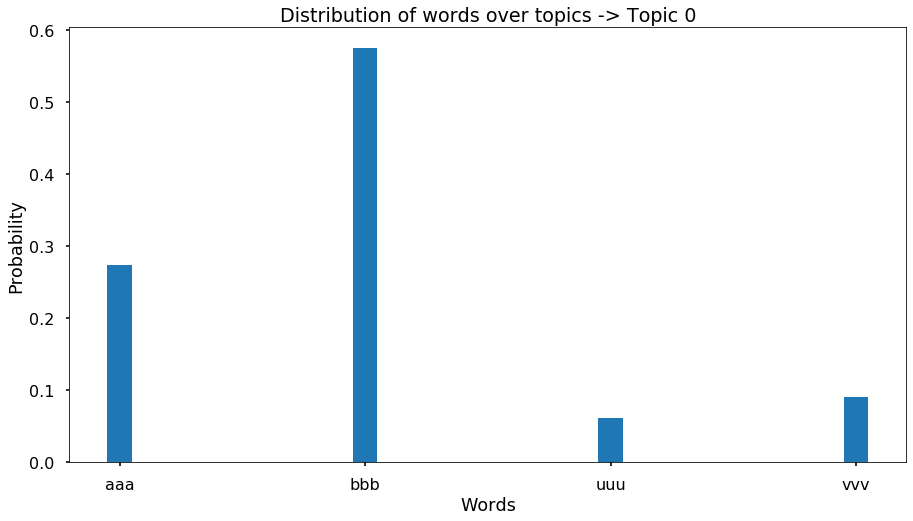

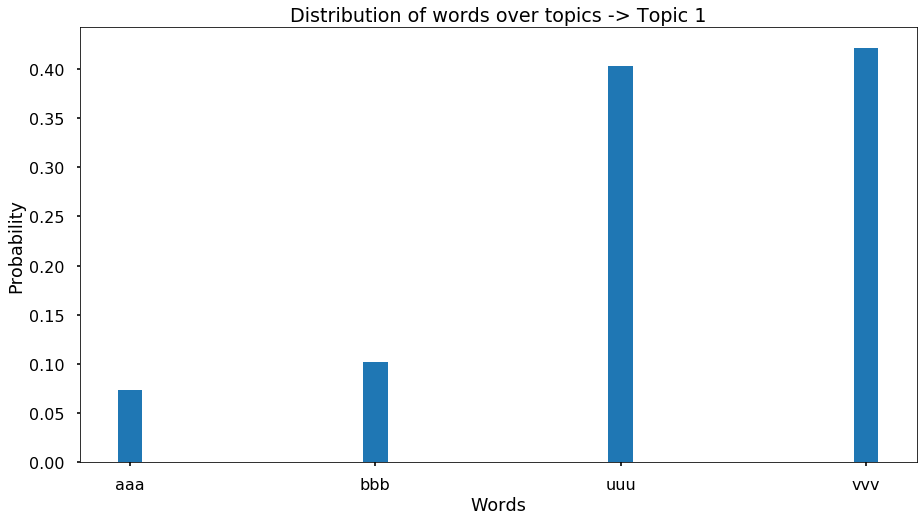

In [12]:
labels = [label for label in lda.get_vocabulary().keys()]

for (i, topic) in enumerate(phi):
    plt.figure(figsize = (15, 8))
    plt.bar(range(len(topic)), topic, width = 0.1 , align='center')
    plt.xticks(range(len(topic)), labels)
    plt.xlabel("Words")
    plt.ylabel('Probability')
    plt.title('Distribution of words over topics -> Topic {}'.format(i))
    plt.show()

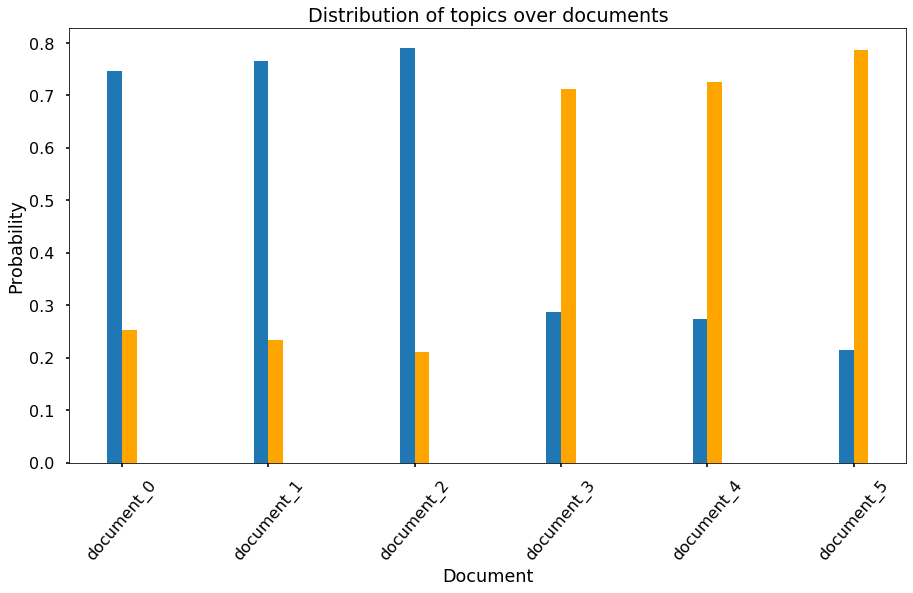

In [13]:
labels = ["document_{}".format(idx) for idx in range(len(corpus))]

plt.figure(figsize = (15, 8))

ax = plt.subplot(111)
w = 0.1

x = np.arange(len(labels))
plt.xticks(x + w / 2, labels, rotation = 50)

ax.bar(np.arange(len(labels)), [document[0] for document in theta] , width = w, align = 'center')
ax.bar(np.arange(len(labels)) + w, [document[1] for document in theta], width = w, color = 'orange', align = 'center')
plt.xlabel("Document")
plt.ylabel('Probability')
plt.title('Distribution of topics over documents')
plt.show()

# Let's check again for alpha = 0.5 and beta = 0.5

 [-----------------100%-----------------] 10000 of 10000 complete in 13.1 sec



[[1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0],
 [0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0]]

Posterior word distributions over topics -> phi variable


[[0.05516698 0.05723719 0.37993878 0.50765705]
 [0.45082558 0.45455156 0.03113864 0.06348422]]


Posterior topic distributions over documents -> theta variable


[[0.11605148 0.88394852]
 [0.15242194 0.84757806]
 [0.09340029 0.90659971]
 [0.81428519 0.18571481]
 [0.82474675 0.17525325]
 [0.86691326 0.13308674]]


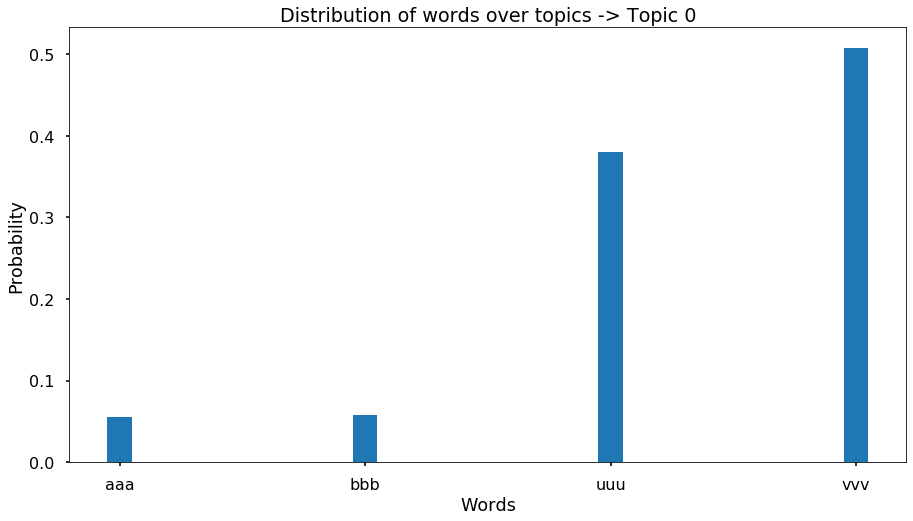

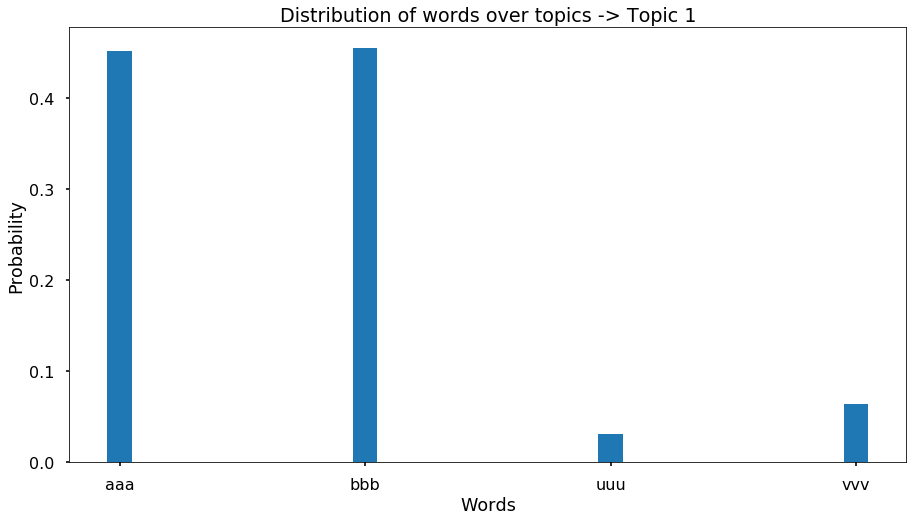

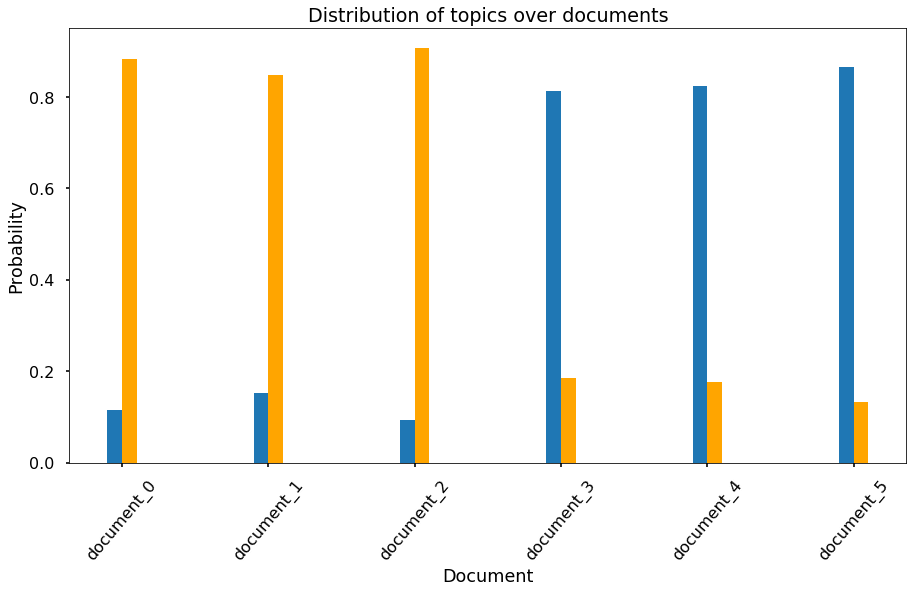

In [14]:
lda = LDA(corpus, K = 2, alpha = 0.5, beta = 0.5, text_cleaner = TextCleaner())
lda.fit(iterations = 10000, burn = 7000)
phi, theta, z = lda.trace()

display(z)

lda.display_posterior_probabilities()

labels = [label for label in lda.get_vocabulary().keys()]

for (i, topic) in enumerate(phi):
    plt.figure(figsize = (15, 8))
    plt.bar(range(len(topic)), topic, width = 0.1 , align='center')
    plt.xticks(range(len(topic)), labels)
    plt.xlabel("Words")
    plt.ylabel('Probability')
    plt.title('Distribution of words over topics -> Topic {}'.format(i))
    plt.show()
    

labels = ["document_{}".format(idx) for idx in range(len(corpus))]

plt.figure(figsize = (15, 8))

ax = plt.subplot(111)
w = 0.1

x = np.arange(len(labels))
plt.xticks(x + w / 2, labels, rotation = 50)

ax.bar(np.arange(len(labels)), [document[0] for document in theta] , width = w, align = 'center')
ax.bar(np.arange(len(labels)) + w, [document[1] for document in theta], width = w, color = 'orange', align = 'center')
plt.xlabel("Document")
plt.ylabel('Probability')
plt.title('Distribution of topics over documents')
plt.show()

- It's normal that sometimes the distributions will look reversed because the document does not know which is the first or the second topic, he just sees that there is a difference between topics.

# Let's check again for alpha = 0.1 and beta = 0.1

 [-----------------100%-----------------] 10000 of 10000 complete in 13.8 sec



[[0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0]]

Posterior word distributions over topics -> phi variable


[[8.93123579e-01 6.95371240e-02 7.17859937e-08 3.73392257e-02]
 [2.89255999e-06 1.32327398e-02 4.41529250e-01 5.45235118e-01]]


Posterior topic distributions over documents -> theta variable


[[9.14407180e-01 8.55928196e-02]
 [9.99939017e-01 6.09827312e-05]
 [9.42491821e-01 5.75081786e-02]
 [1.85596857e-02 9.81440314e-01]
 [1.33995788e-03 9.98660042e-01]
 [4.55987940e-02 9.54401206e-01]]


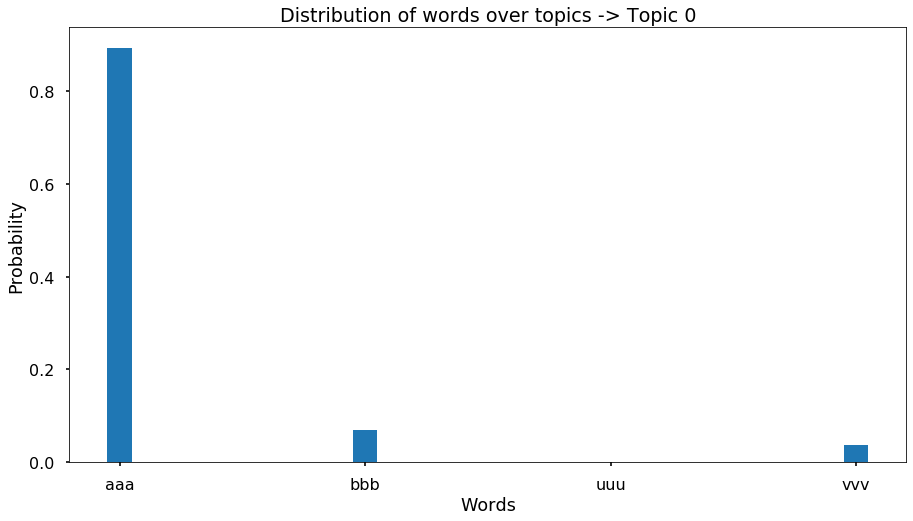

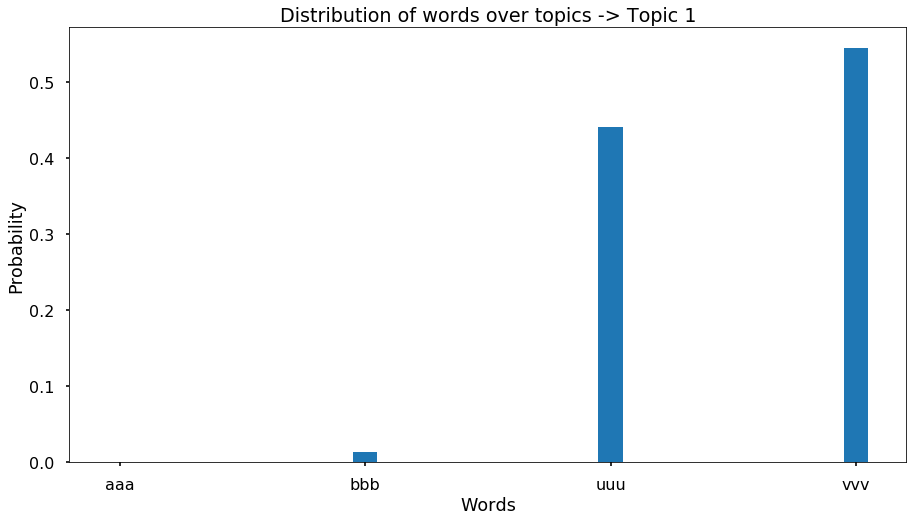

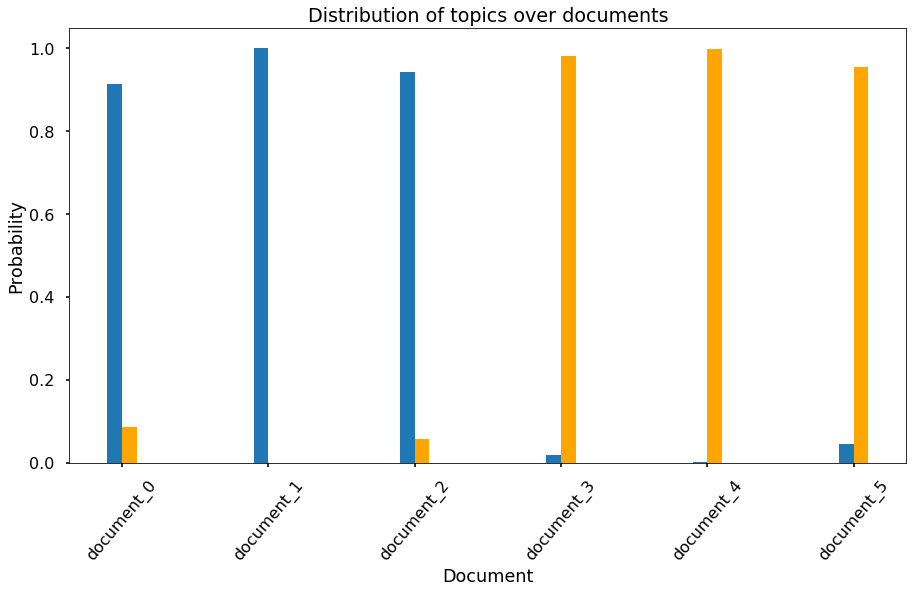

In [18]:
lda = LDA(corpus, K = 2, alpha = 0.1, beta = 0.1, text_cleaner = TextCleaner())
lda.fit(iterations = 10000, burn = 7000)
phi, theta, z = lda.trace()

display(z)

lda.display_posterior_probabilities()

labels = [label for label in lda.get_vocabulary().keys()]

for (i, topic) in enumerate(phi):
    plt.figure(figsize = (15, 8))
    plt.bar(range(len(topic)), topic, width = 0.1 , align='center')
    plt.xticks(range(len(topic)), labels)
    plt.xlabel("Words")
    plt.ylabel('Probability')
    plt.title('Distribution of words over topics -> Topic {}'.format(i))
    plt.show()
    

labels = ["document_{}".format(idx) for idx in range(len(corpus))]

plt.figure(figsize = (15, 8))

ax = plt.subplot(111)
w = 0.1

x = np.arange(len(labels))
plt.xticks(x + w / 2, labels, rotation = 50)

ax.bar(np.arange(len(labels)), [document[0] for document in theta] , width = w, align = 'center')
ax.bar(np.arange(len(labels)) + w, [document[1] for document in theta], width = w, color = 'orange', align = 'center')
plt.xlabel("Document")
plt.ylabel('Probability')
plt.title('Distribution of topics over documents')
plt.show()

# Let's try to understand the hyperparameters
- A higher alpha assumes that each document is likely to contain a mixture of most of the topics
- A higher beta assumes that each topic is likely to contain a mixture of most of the words

# Let's check our LDA for another set of documents

In [19]:
corpus = ["I had a peanuts butter sandwich for breakfast",
          "I like to eat almonds, peanuts and walnuts",
          "My neighbor got a little dog yesterday",
          "Cats and dogs are mortal enemies",
          "You mustn't feed peanuts to your dog"]

# Expected Input Features
$ [[0, 1, 2, 3, 4, 5, 6, 7] $

$ [0, 8, 9, 10, 11, 3, 12, 13] $

$ [14, 15, 16, 2, 17, 18, 19] $

$ [20, 12, 21, 22, 23, 24] $

$ [25, 26, 27, 3, 9, 28, 18]] $

In [20]:
tc = TextCleaner()
features = tc.fit_transform(corpus)
display(features)

[[0, 1, 2, 3, 4, 5, 6, 7],
 [0, 8, 9, 10, 11, 3, 12, 13],
 [14, 15, 16, 2, 17, 18, 19],
 [20, 12, 21, 22, 23, 24],
 [25, 26, 27, 3, 9, 28, 18]]

In [25]:
lda = LDA(corpus, K = 2, alpha = 1, beta = 1, text_cleaner = TextCleaner())
lda.fit(iterations = 10000, burn = 7000)
phi, theta, z = lda.trace()

 [-----------------100%-----------------] 10000 of 10000 complete in 16.2 sec



In [26]:
lda.display_prior_probabilities()

Prior word distributions over topics -> phi variable


[[[1.84725284e-02 4.82079818e-02 5.38532971e-02 1.07986528e-01
   8.95377121e-03 1.35843899e-02 2.96245599e-04 8.22366738e-02
   5.12046923e-03 3.44608276e-03 3.07336375e-02 2.52678702e-02
   4.99077217e-02 1.41604911e-01 3.40658877e-03 1.12580867e-02
   1.61009916e-02 3.47320206e-02 3.22694796e-02 1.09572070e-03
   1.00940314e-03 6.73705487e-03 6.80925876e-02 8.82900438e-03
   4.09949604e-03 7.87338523e-02 2.01712731e-02 8.50804157e-02
   3.87119169e-02]]

 [[2.46076425e-02 5.57589256e-02 9.00572364e-05 1.13479885e-02
   6.60291525e-03 2.27197565e-02 9.09558793e-02 1.61391292e-02
   3.29096770e-02 7.95383331e-02 1.59366805e-02 3.05609797e-03
   2.20193523e-02 3.00420592e-02 1.81199344e-02 5.47224606e-02
   4.15527749e-02 1.15943278e-02 3.54940332e-02 3.93168210e-02
   2.18580908e-02 8.24859675e-02 1.45225563e-02 4.27216345e-02
   7.41965120e-02 2.71882353e-02 2.54985000e-02 1.51375854e-02
   8.38660722e-02]]]


Prior topic distrib

In [27]:
lda.display_posterior_probabilities()

Posterior word distributions over topics -> phi variable


[[4.42106743e-02 8.28865881e-02 3.59261681e-02 1.12343296e-01
  1.36180507e-02 8.14298398e-03 1.34275761e-03 3.85058806e-02
  2.18568050e-02 3.61010535e-02 2.92617490e-02 4.94173054e-02
  2.71296112e-02 9.72846809e-02 1.67900318e-02 2.57069047e-02
  1.02436384e-02 2.50686651e-02 1.23867279e-02 2.91806497e-02
  4.43269151e-02 4.12573218e-03 3.13263177e-02 1.79646450e-02
  1.61148030e-02 4.78992470e-02 2.55533676e-02 5.38247898e-02
  4.14599610e-02]
 [2.31443074e-02 6.33117427e-02 7.57595925e-05 4.28384977e-02
  2.84721463e-02 3.02564922e-02 4.42616329e-02 8.76213842e-03
  2.96417499e-02 9.05243715e-02 2.56445940e-02 2.55291904e-02
  6.16721510e-02 1.96017527e-02 8.00938688e-03 3.68263893e-02
  4.73091086e-02 1.41454722e-02 3.16488572e-02 3.95702877e-02
  6.48340893e-02 5.54078642e-02 1.88467271e-02 1.78362906e-02
  4.58252644e-02 3.98597069e-02 2.34572139e-02 3.28927109e-02
  2.97941044e-02]]


Posterior topic distributions over

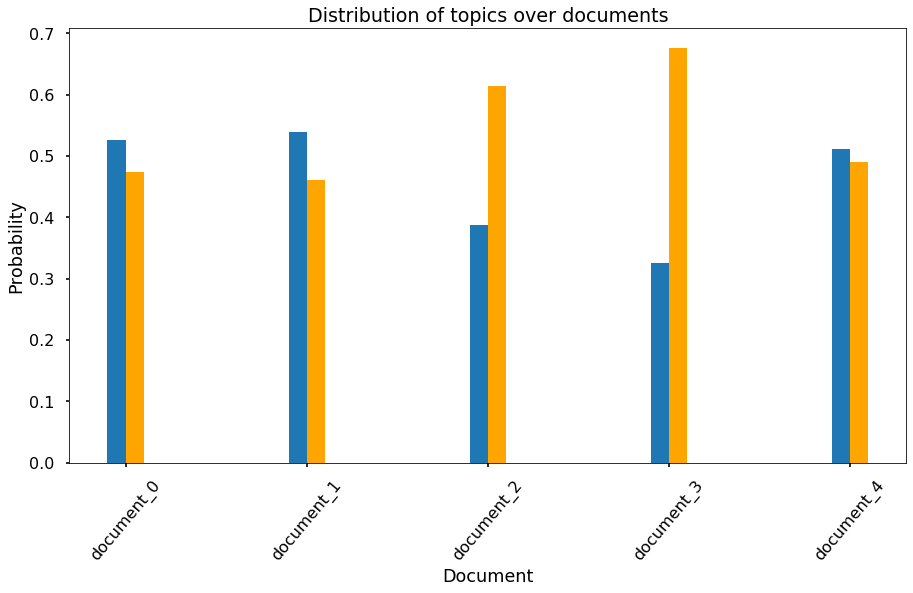

In [28]:
labels = ["document_{}".format(idx) for idx in range(len(corpus))]

plt.figure(figsize = (15, 8))

ax = plt.subplot(111)
w = 0.1

x = np.arange(len(labels))
plt.xticks(x + w / 2, labels, rotation = 50)

ax.bar(np.arange(len(labels)), [document[0] for document in theta] , width = w, align = 'center')
ax.bar(np.arange(len(labels)) + w, [document[1] for document in theta], width = w, color = 'orange', align = 'center')
plt.xlabel("Document")
plt.ylabel('Probability')
plt.title('Distribution of topics over documents')
plt.show()

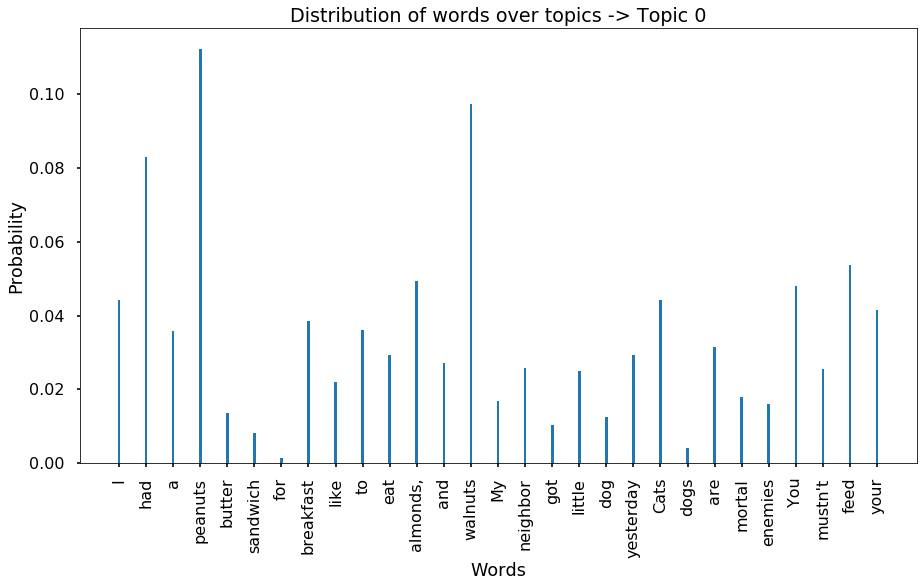

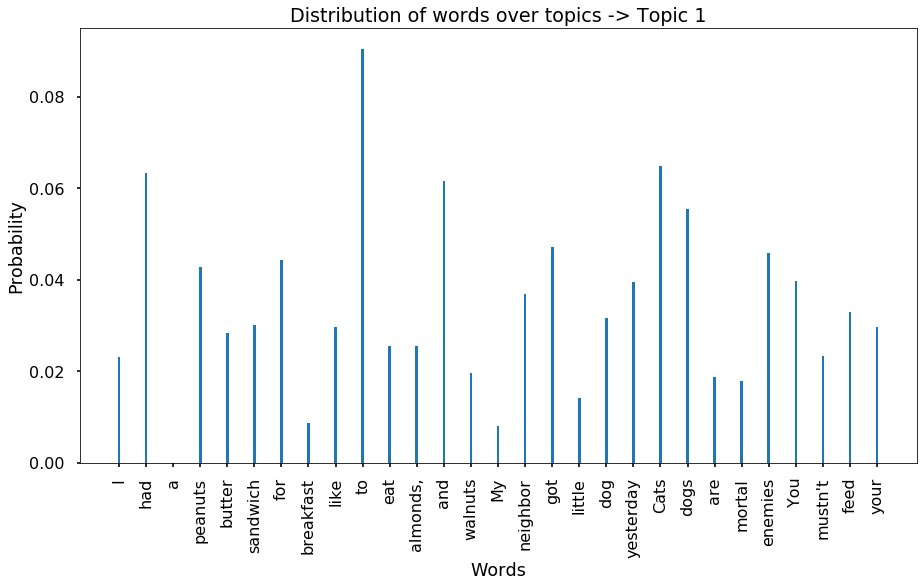

In [29]:
labels = [label for label in lda.get_vocabulary().keys()]

for (i, topic) in enumerate(phi):
    plt.figure(figsize = (15, 8))
    plt.bar(range(len(topic)), topic, width = 0.1 , align='center')
    plt.xticks(range(len(topic)), labels, rotation = 90)
    plt.xlabel("Words")
    plt.ylabel('Probability')
    plt.title('Distribution of words over topics -> Topic {}'.format(i))
    plt.show()

# Alright, here we see a poblem
Despite the fact, the input is the same as in the powerpoint we can observe that:
- There is no stemming or lemmatization, so words like 'dog' and 'dogs' might have different probabilities, but they represent the same thing
- Our LDA might assign high probabilites to various stop words based on frequency, when in fact they carry very little meaning

# So the conclusion... we need a better text cleaner

In [30]:
class AdvancedTextCleaner:
    def __init__(self, drop_frequency:int = 0):
        self.vocabulary = {}
        self.drop_frequency = drop_frequency
        self.lemmatizer = WordNetLemmatizer()
        
    def get_vocabulary(self):
        return self.vocabulary
    
    def find_frequency(self, word: str, corpus: [[str]]) -> int:
        counter = 0
        for document in corpus:
            for word_ in document.split(" "):
                if word_ == word:
                    counter += 1

        return counter
    
    def get_wordnet_pos(self, tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    def clean(self, document: str = None) -> str:    
        # Remove punctuation
        table = str.maketrans('', '', string.punctuation)
        document = document.translate(table)
        
        # Tokenization
        document = nltk.word_tokenize(document)
        
        # Lower case for each word
        document = [word.lower() for word in document]
        
        # Remove stop words
        document = [word for word in document if word not in stop]
        
        # Extract part of speech tags
        document = nltk.tag.pos_tag(document)
        
        # Map pos_tag for lemmatizer
        document = [(word, self.get_wordnet_pos(pos_tag)) for (word, pos_tag) in document]
        
        # Apply lemmatization to text
        document = [self.lemmatizer.lemmatize(word, tag) for (word, tag) in document]
        
        # Let's check again for stop words
        document = [word for word in document if word not in stop]
        
        # Let's converted back to a string
        document = ' '.join(word for word in document)
        
        return document
    
    
    def fit(self, corpus: [str] = None, display_clean_text: bool = False) -> None:
        clean_corpus = [self.clean(document) for document in corpus]
        
        if display_clean_text:
            print("Corpus after text cleaning")
            display(clean_corpus)
            
        clean_corpus = [[word for word in document.split(" ") if self.find_frequency(word, clean_corpus) > self.drop_frequency] for document in clean_corpus]
        clean_corpus = [' '.join(word for word in document) for document in clean_corpus]

        if display_clean_text:
            print("Corpus after removing word with frequency less than {}".format(self.drop_frequency))
            display(clean_corpus)
        
        for document in clean_corpus:
            for word in document.split(" "):
                if word not in self.vocabulary.keys():
                    self.vocabulary[word] = len(self.vocabulary)
                    
                    
    def transform(self, corpus: [str] = None) -> [str]:
        assert bool(self.vocabulary), "[TextCleaner] -> [transform] -> The vocabulary is empty, you must fit the data first"
        
        clean_corpus = [self.clean(document) for document in corpus]
        
        clean_corpus = [[word for word in document.split(" ") if self.find_frequency(word, clean_corpus) > self.drop_frequency] for document in clean_corpus]
        
        clean_corpus = [' '.join(word for word in document) for document in clean_corpus]
        
        features = [[self.vocabulary[word] if word in self.vocabulary.keys() else 0 for word in document.split(" ")] for document in clean_corpus]
        

        return features
    
    def fit_transform(self, corpus: [str] = None, display_clean_text: bool = False) -> [str]:
        self.fit(corpus, display_clean_text)
        return self.transform(corpus)

# Let's check our new text cleaner on a very basic example 

In [31]:
document = "Ana, has the biggest apples and very juicy melons!"
atc = AdvancedTextCleaner()
atc.clean(document)

'ana big apple juicy melon'

# Well, that's much better

# Let's try again on the same example

In [32]:
display(corpus)

['I had a peanuts butter sandwich for breakfast',
 'I like to eat almonds, peanuts and walnuts',
 'My neighbor got a little dog yesterday',
 'Cats and dogs are mortal enemies',
 "You mustn't feed peanuts to your dog"]

In [33]:
atc = AdvancedTextCleaner(drop_frequency = 0)
features = atc.fit_transform(corpus, display_clean_text = True)
display(features)

Corpus after text cleaning


['peanut butter sandwich breakfast',
 'like eat almond peanut walnut',
 'neighbor get little dog yesterday',
 'cat dog mortal enemy',
 'mustnt fee peanut dog']

Corpus after removing word with frequency less than 0


['peanut butter sandwich breakfast',
 'like eat almond peanut walnut',
 'neighbor get little dog yesterday',
 'cat dog mortal enemy',
 'mustnt fee peanut dog']

[[0, 1, 2, 3],
 [4, 5, 6, 0, 7],
 [8, 9, 10, 11, 12],
 [13, 11, 14, 15],
 [16, 17, 0, 11]]

 [-----------------100%-----------------] 10000 of 10000 complete in 11.1 sec

Posterior word distributions over topics -> phi variable


[[3.15234645e-02 6.27536078e-02 5.76707607e-02 1.11113120e-02
  3.65084958e-02 3.90694237e-02 4.76366962e-02 3.40851766e-02
  6.59558610e-02 7.26519410e-02 4.80863219e-02 1.47301657e-01
  4.42212617e-02 7.93118968e-02 7.45900837e-02 1.16772755e-02
  6.54991149e-02 7.03456489e-02]
 [1.90370358e-01 3.66189468e-02 3.88808121e-02 5.48018496e-02
  1.48641768e-01 7.54919453e-02 4.11750830e-02 3.10675590e-02
  3.58683986e-02 5.93160423e-02 5.40282668e-02 4.20100485e-02
  3.76275277e-02 7.02603703e-02 3.86888979e-02 1.25144864e-04
  1.30269358e-02 3.20000448e-02]]


Posterior topic distributions over documents -> theta variable


[[0.29621091 0.70378909]
 [0.28430071 0.71569929]
 [0.58818821 0.41181179]
 [0.62429528 0.37570472]
 [0.58091492 0.41908508]]


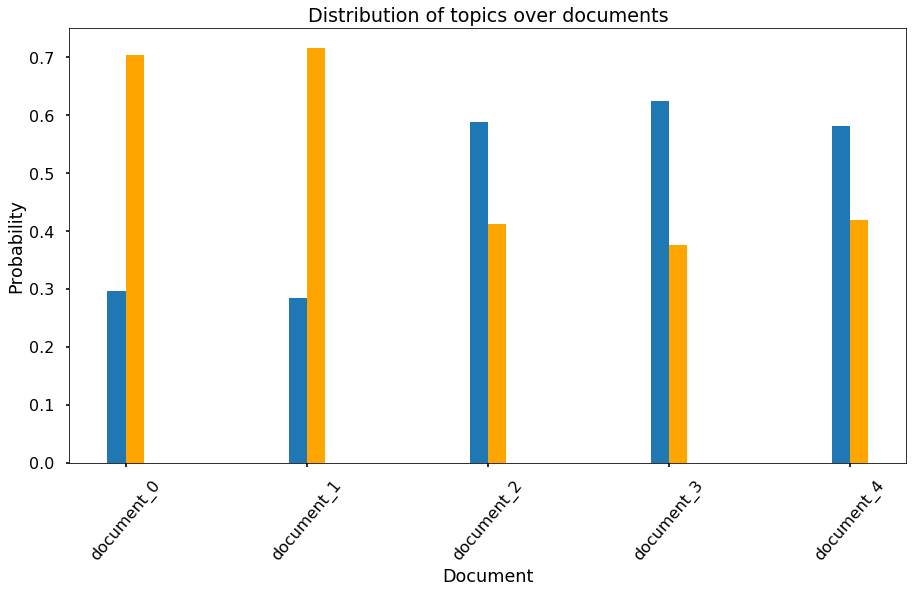

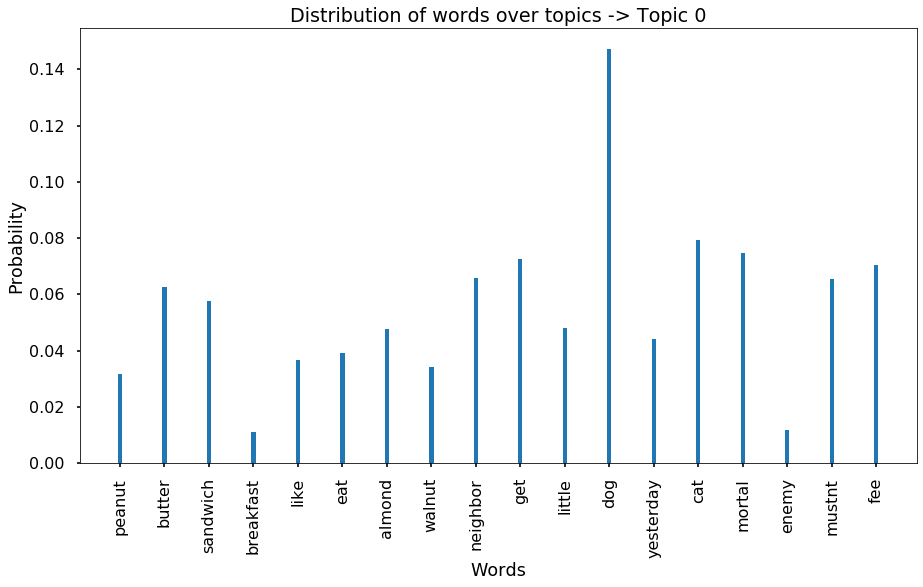

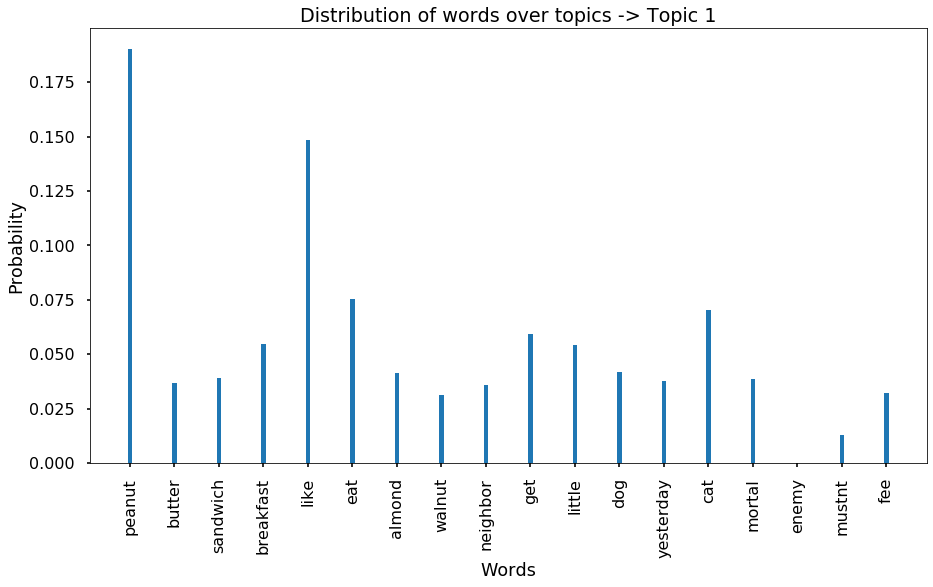

In [35]:
lda = LDA(corpus, K = 2, alpha = 1, beta = 1, text_cleaner = AdvancedTextCleaner(drop_frequency = 0))
lda.fit(iterations = 10000, burn = 7000)
phi, theta, z = lda.trace()

lda.display_posterior_probabilities()

labels = ["document_{}".format(idx) for idx in range(len(corpus))]

plt.figure(figsize = (15, 8))

ax = plt.subplot(111)
w = 0.1

x = np.arange(len(labels))
plt.xticks(x + w / 2, labels, rotation = 50)

ax.bar(np.arange(len(labels)), [document[0] for document in theta] , width = w, align = 'center')
ax.bar(np.arange(len(labels)) + w, [document[1] for document in theta], width = w, color = 'orange', align = 'center')
plt.xlabel("Document")
plt.ylabel('Probability')
plt.title('Distribution of topics over documents')
plt.show()


labels = [label for label in lda.get_vocabulary().keys()]

for (i, topic) in enumerate(phi):
    plt.figure(figsize = (15, 8))
    plt.bar(range(len(topic)), topic, width = 0.1 , align='center')
    plt.xticks(range(len(topic)), labels, rotation = 90)
    plt.xlabel("Words")
    plt.ylabel('Probability')
    plt.title('Distribution of words over topics -> Topic {}'.format(i))
    plt.show()

# Let's make a new corpus and try it

In [36]:
# topics: sports, politics, food, animals
own_corpus = ["To play tennis, you need just a ball, tennis rackets and players",
             "Every four years a new president is elected, this year Biden was elected, not Trump", 
             "A healty food diet contains fruits, vegetables, meat and water",
             "If you want a dog or a cat or any animal you can go to the pet store",
             
              "Every sport needs competitive players, like Nadal in tennis",
              "In the last four years while Trump was the elected president taxes went low",
              "Your food in the fridge, besides fruits and vegetables is expired",
              "I own two cats and a dog, I am a dog person, but if you like cats I have no problem with that",
              
              "Every competitive player in sports trains twice a day, in tennis just once",
              "I like every fruit but very few vegetables, but my food diet contains much more meat then fruits",
              "While democrats support Biden and republicans supports Trumps, the media divided the country",
              "Any domestic animal, like dogs or cats, needs attention, but wild animals do not",
              
              "Swimming and tennis are the best sports competitive players",
              "My diet is only based on water red meat and vegetables", 
              "There was a conflict with China while Trump was president, but now with the Biden as elected president negotiations are back",
              "I prefer animals as friends, especially dogs, cats are not so loyal"
             ]

In [37]:
cleaned = [atc.clean(doc) for doc in own_corpus]
cleaned

['play tennis need ball tennis racket player',
 'every four year new president elect year biden elect trump',
 'healty food diet contain fruit vegetable meat water',
 'want dog cat animal go pet store',
 'every sport need competitive player like nadal tennis',
 'last four year trump elect president tax go low',
 'food fridge besides fruit vegetable expire',
 'two cat dog dog person like cat problem',
 'every competitive player sport train twice day tennis',
 'like every fruit vegetables food diet contain much meat fruit',
 'democrat support biden republican support trump medium divide country',
 'domestic animal like dog cat need attention wild animal',
 'swim tennis best sport competitive player',
 'diet base water red meat vegetable',
 'conflict china trump president biden elect president negotiation back',
 'prefer animal friends especially dogs cat loyal']

 [-----------------100%-----------------] 10000 of 10000 complete in 62.1 sec

Posterior word distributions over topics -> phi variable


[[3.47051241e-02 2.17909724e-03 3.20558847e-02 2.95604436e-04
  3.25976333e-04 5.73013909e-04 5.53150230e-03 4.57399261e-02
  2.09899326e-02 2.62466737e-02 3.56661028e-03 7.60251230e-03
  2.93430146e-02 1.92622585e-03 4.27504069e-02 9.96601278e-03
  3.51916715e-02 4.92582431e-04 2.74272874e-02 2.20899478e-03
  2.79376128e-03 2.35017700e-04 6.40671199e-03 3.91359467e-04
  1.93096934e-02 3.48335970e-06 3.24985928e-02 2.01814906e-03
  1.96011772e-03 1.60273622e-02 8.96033942e-03 2.30483551e-02
  1.95167434e-02 3.03595276e-04 4.78386990e-04 1.12851126e-03
  3.19644413e-04 9.02995810e-02 9.28505758e-04 2.05719169e-02
  3.72019640e-03 7.64295799e-06 3.78571644e-04 1.51730463e-03
  7.98286337e-03 8.83393561e-04 5.52060498e-02 2.53539775e-02
  2.03014630e-02 5.09491402e-03 8.36433615e-03 3.74516158e-02
  7.71354207e-03 4.36895735e-03 4.50657322e-02 5.8918962

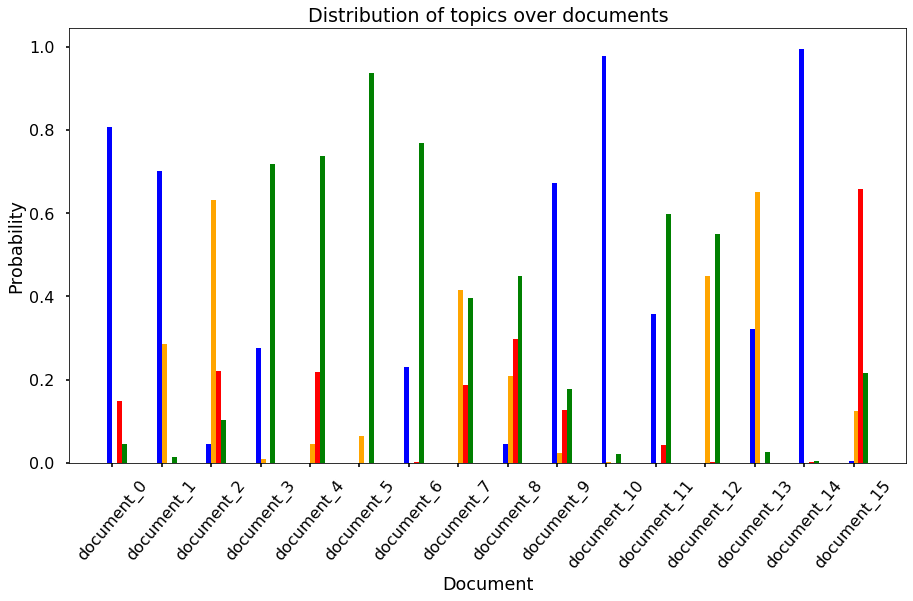

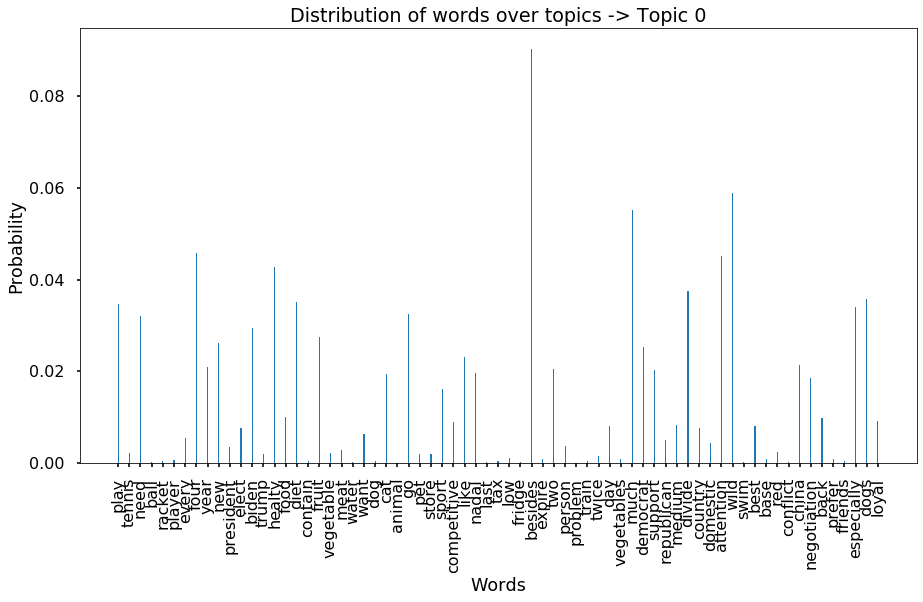

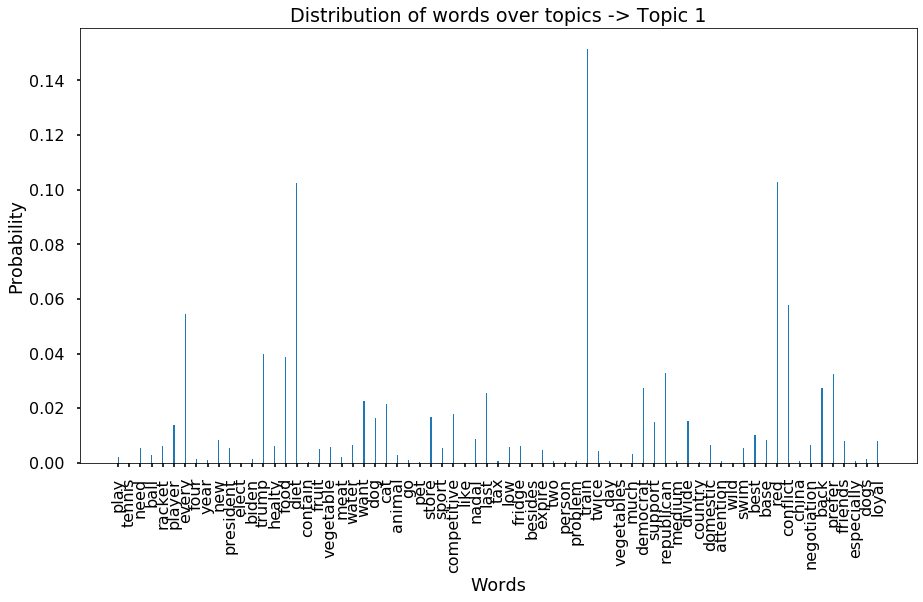

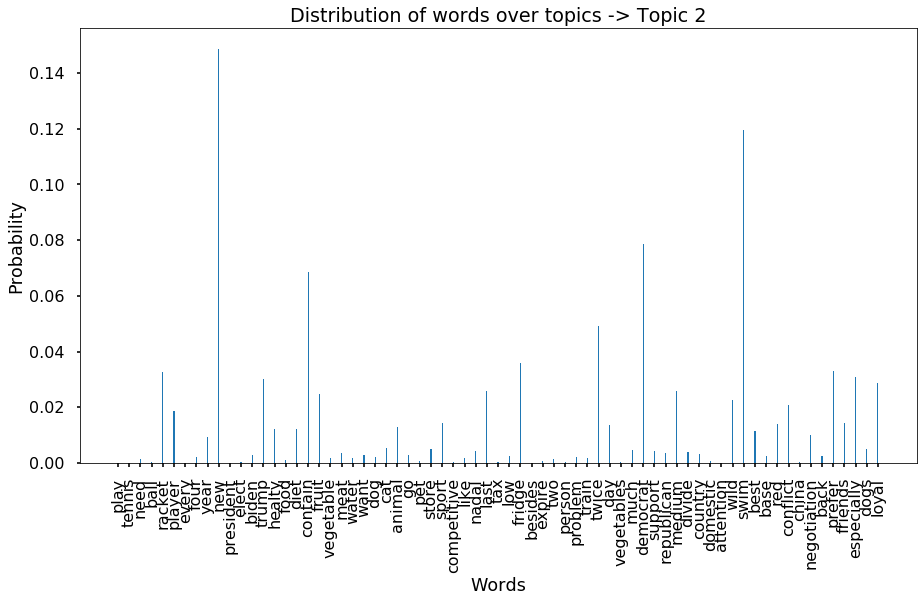

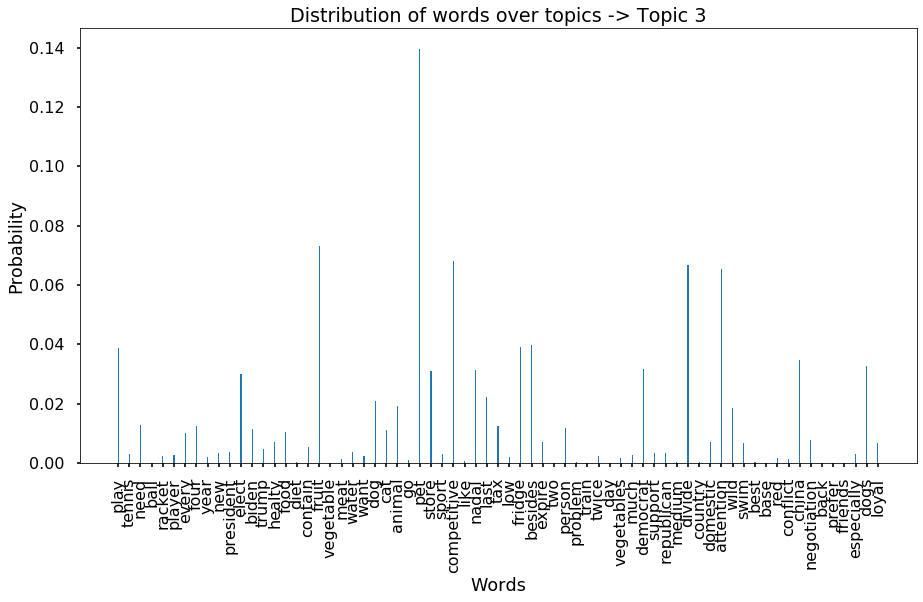

In [57]:
lda = LDA(own_corpus, K = 4, alpha = 0.2, beta = 0.5, text_cleaner = AdvancedTextCleaner())
lda.fit(iterations = 10000, burn = 7000)
phi, theta, z = lda.trace()

lda.display_posterior_probabilities()

labels = ["document_{}".format(idx) for idx in range(len(own_corpus))]

plt.figure(figsize = (15, 8))

ax = plt.subplot(111)
w = 0.1

x = np.arange(len(labels))
plt.xticks(x + w / 2, labels, rotation = 50)

topics = ["sports", "politics", "food", "animals"]
colors = ["blue", "orange", "red", "green"]
for i in range(4):
    ax.bar(np.arange(len(labels)) + i * w, [document[i] for document in theta], width = w, color = colors[i], label = topics[i], align = 'center')   
    
plt.xlabel("Document")
plt.ylabel('Probability')
plt.title('Distribution of topics over documents')
plt.show()


labels = [label for label in lda.get_vocabulary().keys()]

for (i, topic) in enumerate(phi):
    plt.figure(figsize = (15, 8))
    plt.bar(range(len(topic)), topic, width = 0.1 , align='center')
    plt.xticks(range(len(topic)), labels, rotation = 90)
    plt.xlabel("Words")
    plt.ylabel('Probability')
    plt.title('Distribution of words over topics -> Topic {}'.format(i))
    plt.show()

# Removing words based on frequency in corpus
- This idea is based on intuition and past experiments
- From past experiments we can see that low frequency words might gain high probabilities
- This represents a problem because low frequency words do not help in distinguishing topics

In [39]:
atc = AdvancedTextCleaner()
features = atc.fit_transform(own_corpus)
display(features)

atc = AdvancedTextCleaner(drop_frequency = 1)
frequency_features = atc.fit_transform(own_corpus)
display(frequency_features)

[[0, 1, 2, 3, 1, 4, 5],
 [6, 7, 8, 9, 10, 11, 8, 12, 11, 13],
 [14, 15, 16, 17, 18, 19, 20, 21],
 [22, 23, 24, 25, 26, 27, 28],
 [6, 29, 2, 30, 5, 31, 32, 1],
 [33, 7, 8, 13, 11, 10, 34, 26, 35],
 [15, 36, 37, 18, 19, 38],
 [39, 24, 23, 23, 40, 31, 24, 41],
 [6, 30, 5, 29, 42, 43, 44, 1],
 [31, 6, 18, 45, 15, 16, 17, 46, 20, 18],
 [47, 48, 12, 49, 48, 13, 50, 51, 52],
 [53, 25, 31, 23, 24, 2, 54, 55, 25],
 [56, 1, 57, 29, 30, 5],
 [16, 58, 21, 59, 20, 19],
 [60, 61, 13, 10, 12, 11, 10, 62, 63],
 [64, 25, 65, 66, 67, 24, 68]]

[[0, 1, 0, 2],
 [3, 4, 5, 6, 7, 5, 8, 7, 9],
 [10, 11, 12, 13, 14, 15, 16],
 [17, 18, 19, 20],
 [3, 21, 1, 22, 2, 23, 0],
 [4, 5, 9, 7, 6, 20],
 [10, 13, 14],
 [18, 17, 17, 23, 18],
 [3, 22, 2, 21, 0],
 [23, 3, 13, 10, 11, 12, 15, 13],
 [24, 8, 24, 9],
 [19, 23, 17, 18, 1, 19],
 [0, 21, 22, 2],
 [11, 16, 15, 14],
 [9, 6, 8, 7, 6],
 [19, 18]]

 [-----------------100%-----------------] 10000 of 10000 complete in 59.5 sec

Posterior word distributions over topics -> phi variable


[[1.27401172e-02 6.72744148e-02 1.08495025e-02 2.61549601e-02
  7.59579254e-03 2.68599073e-02 1.20108310e-02 6.43537054e-02
  7.54807824e-03 3.65982589e-02 4.38818866e-02 2.03639906e-01
  6.92249671e-03 2.79859881e-02 1.23141648e-01 1.07246985e-02
  4.94711083e-02 1.83524674e-02 3.33482253e-02 1.63987858e-02
  7.57438376e-02 8.85372546e-03 5.87146503e-03 4.68353572e-02
  5.68428371e-02]
 [7.12216213e-03 4.47935024e-05 2.67533943e-02 5.11224746e-02
  1.67697182e-02 1.03532535e-02 2.15244260e-02 2.83618194e-02
  8.01583946e-02 4.37482515e-02 3.87633669e-02 3.29658119e-02
  2.36504754e-03 1.31344327e-03 6.13613033e-03 1.09567085e-02
  2.48050678e-02 1.33288835e-01 8.71938903e-02 7.68977942e-02
  3.42229835e-02 5.58550336e-03 5.99805953e-02 7.62469720e-02
  1.23319162e-01]
 [2.23916088e-02 5.42092256e-02 1.12380536e-02 6.72166371e-02
  8.71179841e-03 1.4

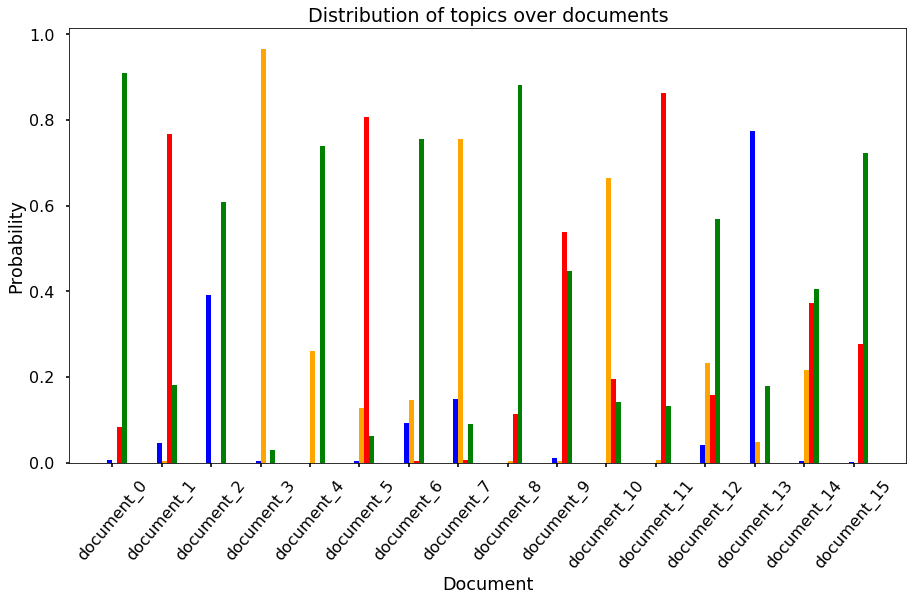

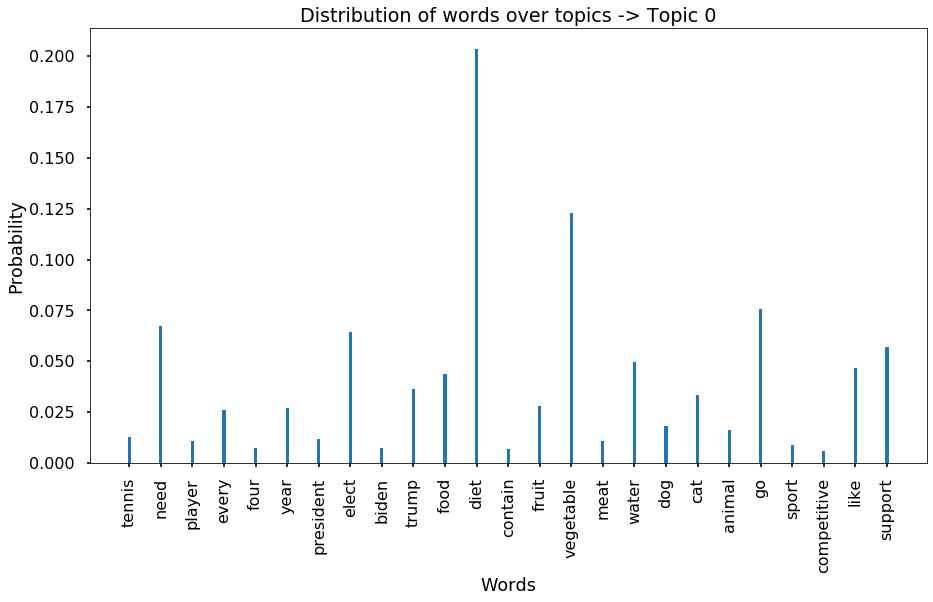

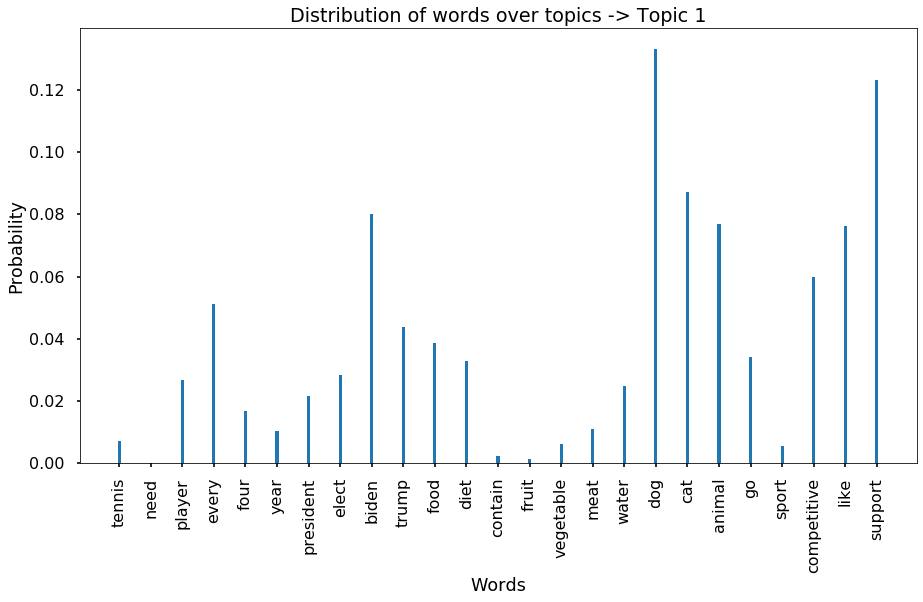

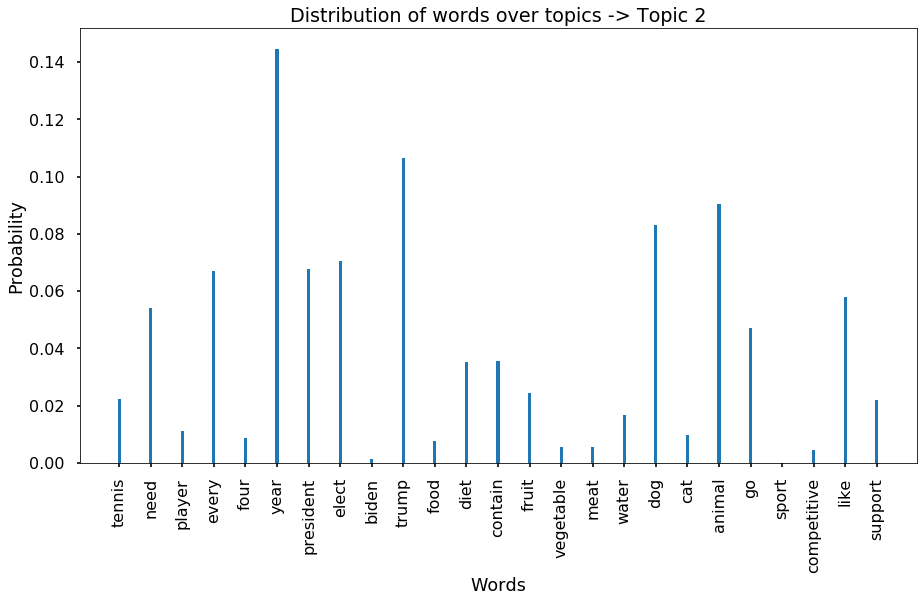

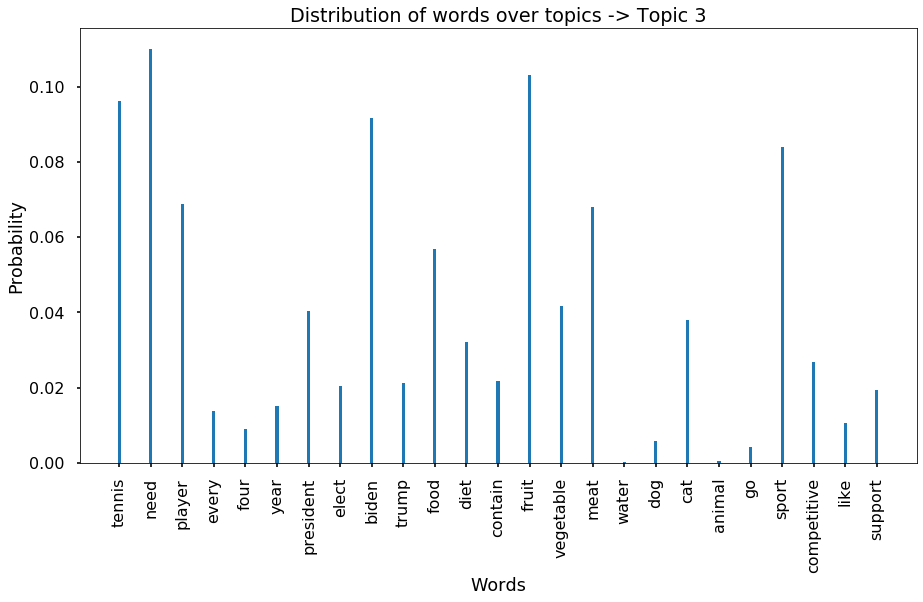

In [70]:
lda = LDA(own_corpus, K = 4, alpha = 0.2, beta = 0.8, text_cleaner = AdvancedTextCleaner(drop_frequency = 1))
lda.fit(iterations = 10000, burn = 7000)
phi, theta, z = lda.trace()

lda.display_posterior_probabilities()

labels = ["document_{}".format(idx) for idx in range(len(own_corpus))]

plt.figure(figsize = (15, 8))

ax = plt.subplot(111)
w = 0.1

x = np.arange(len(labels))
plt.xticks(x + w / 2, labels, rotation = 50)

topics = ["sports", "politics", "food", "animals"]
colors = ["blue", "orange", "red", "green"]
for i in range(4):
    ax.bar(np.arange(len(labels)) + i * w, [document[i] for document in theta], width = w, color = colors[i], label = topics[i], align = 'center')   
    
plt.xlabel("Document")
plt.ylabel('Probability')
plt.title('Distribution of topics over documents')
plt.show()


labels = [label for label in lda.get_vocabulary().keys()]

for (i, topic) in enumerate(phi):
    plt.figure(figsize = (15, 8))
    plt.bar(range(len(topic)), topic, width = 0.1 , align='center')
    plt.xticks(range(len(topic)), labels, rotation = 90)
    plt.xlabel("Words")
    plt.ylabel('Probability')
    plt.title('Distribution of words over topics -> Topic {}'.format(i))
    plt.show()

# Measuring similarities between documents
- In this part will use theta variable representing the distribution of topics over documents 
- Will compute for each document with each document the cosine and jensenshannon distance

In [71]:
print(theta)

[[6.65143730e-03 6.75765143e-07 8.31076249e-02 9.10240262e-01]
 [4.65123070e-02 4.33091012e-03 7.67991217e-01 1.81165566e-01]
 [3.91761395e-01 7.49076374e-06 9.87495231e-06 6.08221240e-01]
 [3.42368321e-03 9.66633933e-01 1.16475758e-06 2.99412186e-02]
 [1.12426512e-05 2.59837539e-01 2.39496990e-09 7.40151216e-01]
 [5.09418221e-03 1.27092777e-01 8.06319662e-01 6.14933790e-02]
 [9.26670281e-02 1.47461815e-01 3.76122244e-03 7.56109934e-01]
 [1.49512728e-01 7.54980235e-01 5.50043747e-03 9.00065992e-02]
 [2.63184815e-04 3.92228335e-03 1.13869683e-01 8.81944849e-01]
 [1.00913810e-02 3.17074444e-03 5.39310289e-01 4.47427586e-01]
 [3.58649888e-07 6.63442377e-01 1.94656738e-01 1.41900526e-01]
 [1.91966471e-04 5.95342573e-03 8.62041374e-01 1.31813234e-01]
 [4.11601253e-02 2.31809875e-01 1.57714220e-01 5.69315779e-01]
 [7.73241193e-01 4.87613173e-02 7.18948255e-05 1.77925595e-01]
 [3.77311916e-03 2.16823362e-01 3.73657464e-01 4.05746055e-01]
 [5.98309683e-04 1.69577150e-05 2.76966686e-01 7.224180

In [72]:
cosine_similarity = [[distance.cosine(document_1, document_2) for document_1 in theta] for document_2 in theta] 
jensenshannon_similarity = [[distance.jensenshannon(document_1, document_2) for document_1 in theta] for document_2 in theta] 

# Cosine Similarity

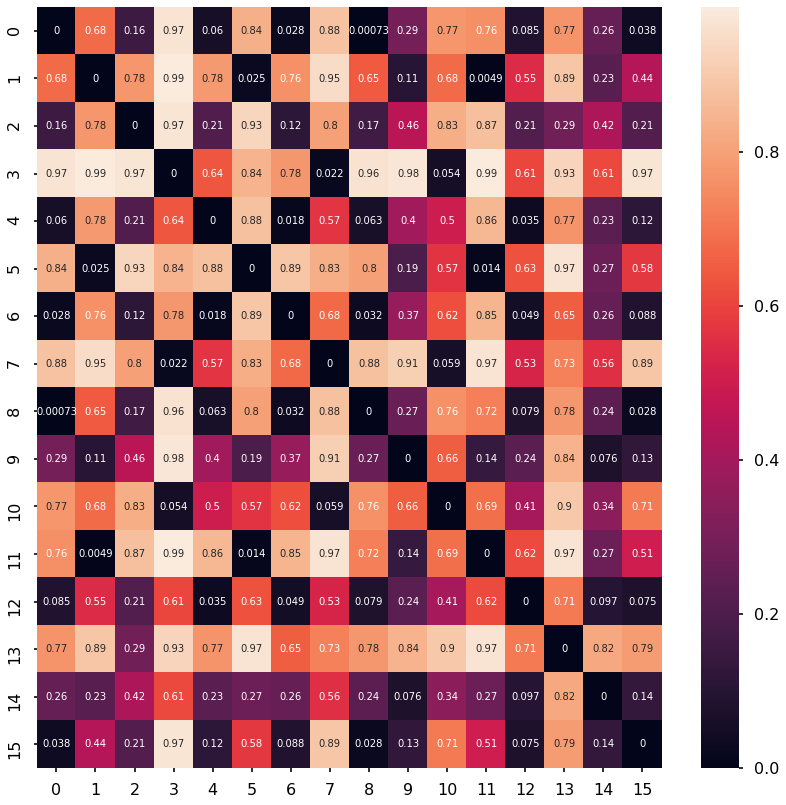

In [73]:
plt.figure(figsize = (14, 14))
sns.heatmap(np.array(cosine_similarity), annot = True)
plt.show()

# Jensen Shannon Similarity

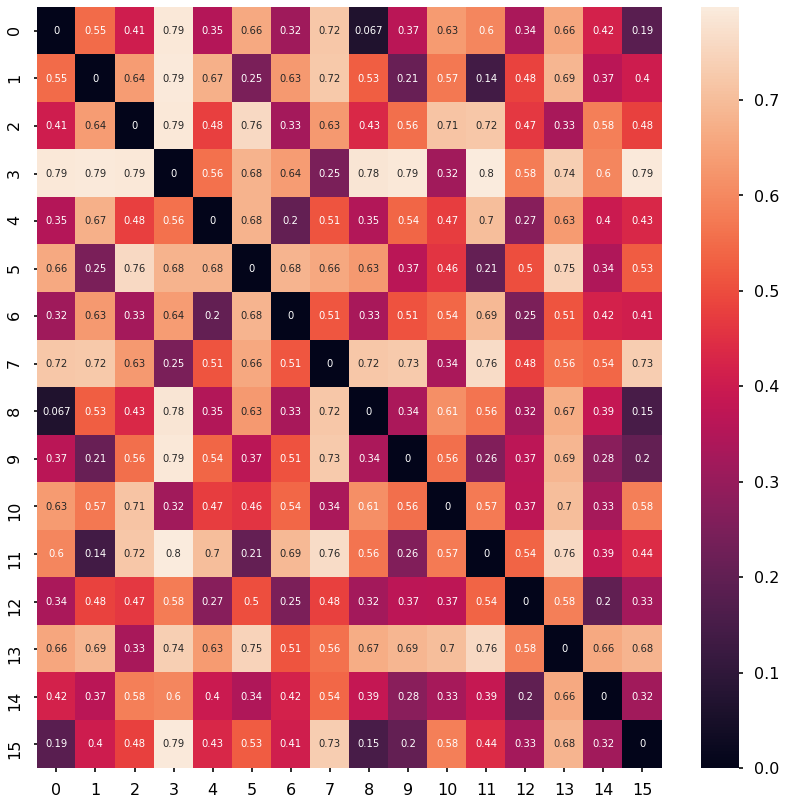

In [74]:
plt.figure(figsize = (14, 14))
sns.heatmap(np.array(jensenshannon_similarity), annot = True)
plt.show()

# Assigning topics to a new document
- Step 1: Add the new document to corpus and redo the preprocessing steps
- Step 2: After the feature vector is created iterate through topics and sum probabilities for each feature
- Step 3: Summing probabilities will not give us probabilities, so will apply softmax to remap them to probabilities

In [75]:
new_document = "Biden is the new elected president for the next four years"

own_corpus.append(new_document)

In [77]:
atc = AdvancedTextCleaner(drop_frequency = 1)
new_features = atc.fit_transform(own_corpus)
new_features = new_features[-1]

print("Input features for new document")
print(new_features)

probabilities = []
for topic in range(4):
    proba = 0
    
    for feature in new_features:
        proba += phi[topic][feature]
    
    probabilities.append(proba)

print("Before Softmax")
print("Probabilities {} -> Sum {}".format(probabilities, np.sum(np.round(probabilities, 3))))

print("After Softmax")
print("Probabilities {} -> Sum {}".format(softmax(probabilities), np.sum(softmax(probabilities))))

Input features for new document
[9, 6, 8, 7, 4, 5]
Before Softmax
Probabilities [0.1549665733662577, 0.20091586308111295, 0.3996179323860766, 0.19798479508853095] -> Sum 0.954
After Softmax
Probabilities [0.22892965 0.23969422 0.29238344 0.23899269] -> Sum 0.9999999999999998


# Things that did not work
- Trying to optimize the number of iterations and burn samples (I found it important to burn more samples so that the remaining samples will help the mean to converge to better results)
- Trying to use last samples from phi and theta instead of mean
- Using it without removing low frequency words or removing stop words
- Text cleanning not that useful
- Hard to optimize alpha and beta because the experiments cannot be reproduced